In [38]:

# !pip install transformers -U
# !pip install wget
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable
import os
print(os.path)

# For plots
%matplotlib inline
import matplotlib.pyplot as plt

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

<module 'posixpath' from '/usr/lib/python3.6/posixpath.py'>
There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [48]:
import wget
import os
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jianhuibenben","key":"d6a04ab9c7576ada5ef8950c2460bf4a"}'}

In [51]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#kaggle datasets download -d snap/amazon-fine-food-reviews
!kaggle datasets download -d snap/amazon-fine-food-reviews

 97% 235M/242M [00:04<00:00, 48.3MB/s]
100% 242M/242M [00:04<00:00, 51.3MB/s]


In [52]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./amazon_food_reviews/'):
    !unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [60]:
import pandas as pd
import torch
from transformers import *
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import time
import datetime

%matplotlib inline

reviews = pd.read_csv("Reviews.csv")
reviews['ProductId']=reviews['ProductId'].astype(str)
df=reviews[['ProductId', 'Text', 'Summary']]
df.head()

,ProductId,Text,Summary
0,B001E4KFG0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,B00813GRG4,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,B000LQOCH0,This is a confection that has been around a fe...,"""Delight"" says it all"
3,B000UA0QIQ,If you are looking for the secret ingredient i...,Cough Medicine
4,B006K2ZZ7K,Great taffy at a great price. There was a wid...,Great taffy


In [61]:
#clean the text and the summary, there're some duplicates
df=df.drop_duplicates(keep=False)
len(df)

567003

8


(array([663., 214.,  64.,  26.,  19.,   6.,   4.,   1.,   2.,   1.]),
 array([ 18., 100., 182., 264., 346., 428., 510., 592., 674., 756., 838.]),
 <a list of 10 Patch objects>)

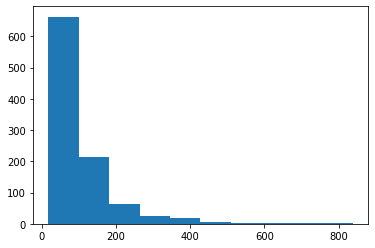

In [79]:
model = BartForConditionalGeneration.from_pretrained('bart-large-cnn') ### pos:1026; dim: 1024 
tokenizer = BartTokenizer.from_pretrained('bart-large-cnn')
## most reviews' lengths are shorter than 512 tokens, so I use max_len=512 to save some compute
tokens_counts=[len(tokenizer.tokenize(sent)) for sent in df.sample(n = 1000)['Text']]
print(sum(np.array(tokens_counts)>512))
plt.hist(tokens_counts)  

In [81]:
### less fancy way to tokenize
input_token_ids=[]
for sent in df['Text']:
    input_token_ids.append(tokenizer.encode(sent,                         
                            max_length = 512))      # Truncate all sentences.
#                             return_tensors = 'pt'))     # Return pytorch tensors.

# Print the original sentence.
print(' Original: ', df['Text'][0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(df['Text'][0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df['Text'][0])))

## tokenize.encode can handle both two steps above, and then add special tokens [start] and [end]
print('Token IDs aftern encoding: ', tokenizer.encode(df['Text'][0]))

 Original:  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Tokenized:  ['I', 'Ġhave', 'Ġbought', 'Ġseveral', 'Ġof', 'Ġthe', 'ĠVital', 'ity', 'Ġcanned', 'Ġdog', 'Ġfood', 'Ġproducts', 'Ġand', 'Ġhave', 'Ġfound', 'Ġthem', 'Ġall', 'Ġto', 'Ġbe', 'Ġof', 'Ġgood', 'Ġquality', '.', 'ĠThe', 'Ġproduct', 'Ġlooks', 'Ġmore', 'Ġlike', 'Ġa', 'Ġstew', 'Ġthan', 'Ġa', 'Ġprocessed', 'Ġmeat', 'Ġand', 'Ġit', 'Ġsmells', 'Ġbetter', '.', 'ĠMy', 'ĠLabrador', 'Ġis', 'Ġfin', 'icky', 'Ġand', 'Ġshe', 'Ġappreci', 'ates', 'Ġthis', 'Ġproduct', 'Ġbetter', 'Ġthan', 'Ġ', 'Ġmost', '.']
Token IDs:  [100, 33, 2162, 484, 9, 5, 23911, 1571, 24623, 2335, 689, 785, 8, 33, 303, 106, 70, 7, 28, 9, 205, 1318, 4, 20, 1152, 1326, 55, 101, 10, 24571, 87, 10, 12069, 4884, 8, 24, 28078, 357, 4, 1308, 26882, 16, 8746, 14963,

In [159]:
## Tokenize
tokenizer.batch_encode_plus(list(df['Text']), max_length=512, pad_to_max_length=True, return_tensors = 'pt')['input_ids']


57

In [91]:
tokenizer.convert_tokens_to_ids('-100')

3

In [0]:
# dir(tokenizer)

In [127]:
tokenizer.convert_ids_to_tokens(579)

'Ġs'

In [110]:
tokenizer.all_special_ids

[50264, 2, 0, 3, 1]

In [93]:
tokenizer.all_special_tokens

['<mask>', '</s>', '<s>', '<unk>', '<pad>']

In [0]:
tokenizer.tokenize(df['Text'][0],add_special_tokens=True, max_length=60, pad_to_max_length=True, return_tensors = 'pt')

In [0]:
test=tokenizer.batch_encode_plus(list(df['Text'][[0]]), max_length=512, pad_to_max_length=True, return_tensors = 'pt')['input_ids']


Here stops


In [164]:
test

tensor([[    0,    38,    33,  2162,   484,     9,     5, 23911,  1571, 24623,
          2335,   689,   785,     8,    33,   303,   106,    70,     7,    28,
             9,   205,  1318,     4,    20,  1152,  1326,    55,   101,    10,
         24571,    87,    10, 12069,  4884,     8,    24, 28078,   357,     4,
          1308, 26882,    16,  8746, 14963,     8,    79, 14137,  1626,    42,
          1152,   357,    87,  1437,   144,     4,     2,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [130]:
len(tokenizer.batch_encode_plus(list(df['Text'][0]), max_length=30, pad_to_max_length=True, add_special_tokens=True)['input_ids'])

263

In [141]:
len(df['Text'][0])

263

In [144]:
len(tokenizer.batch_encode_plus(list(df['Text'][[0]]), max_length=60, pad_to_max_length=True, add_special_tokens=True)['input_ids'][0])

60

In [0]:
test=tokenizer.batch_encode_plus(list(df['Text'][0:2]), max_length=60, pad_to_max_length=True, return_attention_masks=True)

In [158]:
# test['input_ids']
len(test['attention_mask'][0])

60

In [0]:
list(df['Text'][0:2])

In [69]:
tokenizer.encode(""""Delight" says it all""")

[0, 22, 21502, 5971, 113, 161, 24, 70, 2]

In [71]:
tokenizer.encode('it')

[0, 24, 2]

In [64]:
tokenizer.encode('good')

[0, 205, 2]

In [39]:
##BART
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig
# see ``examples/summarization/bart/evaluate_cnn.py`` for a longer example
model = BartForConditionalGeneration.from_pretrained('bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('bart-large-cnn')
ARTICLE_TO_SUMMARIZE = "this coffee is getting cold."
inputs = tokenizer.encode([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt')
# Generate Summary
summary_ids = model.generate(inputs, num_beams=4, max_length=5, early_stopping=True)
print([tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

['']


In [26]:
inputs = tokenizer.batch_encode_plus([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt')
inputs['input_ids']

tensor([[   0, 1308,  766,   16, 1664,    6,    8,   38,  657,   83, 9691,  182,
          203,    2]])

In [31]:
[tokenizer.decode(i) for i in model.generate(inputs)]

['</s><s>"I love Aiko very much. My name is Ben, and I love her very much," he says. "I love her with all my heart and soul," he adds. "Aiko, I love you very much" "I want to be with you forever," Aiko replies. "Yes, I do," Ben says.']

In [10]:
ARTICLE_TO_SUMMARIZE='My name is Ben, and I love Aiko very much'
inputs = tokenizer.batch_encode_plus([ARTICLE_TO_SUMMARIZE], max_length=1024, return_tensors='pt')
# Generate Summary
summary_ids =  #, num_beams=4, max_length=5, early_stopping=True
print([model.generate(inputs['input_ids'])(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids])

['"I love Aiko very much. My name is Ben, and I love her very much," he says. "I love her with all my heart and soul," he adds. "Aiko, I love you very much" "I want to be with you forever," Aiko replies. "Yes, I do," Ben says.']


In [0]:
# model
from transformers import BertTokenizer
bert_tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
input_id= bert_tokenizer.encode('Who am I? I am a man', return_tensors='pt')

In [36]:
input_id

tensor([[ 101, 2040, 2572, 1045, 1029, 1045, 2572, 1037, 2158,  102]])

In [40]:
from transformers import PreTrainedEncoderDecoder
model= PreTrainedEncoderDecoder.from_pretrained('bert-base-uncased', 'gpt2')
from transformers import BertTokenizer
bert_tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
input_id= bert_tokenizer.encode('Who am I? I am a', return_tensors='pt')
model.decode(input_id)

AttributeError: ignored

In [74]:
# bart model struecture:
params=list(model.named_parameters())
# len(params)
for p in params[:10]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

model.shared.weight                                     (50264, 1024)
model.encoder.embed_positions.weight                    (1026, 1024)
model.encoder.layers.0.self_attn.k_proj.weight          (1024, 1024)
model.encoder.layers.0.self_attn.k_proj.bias                 (1024,)
model.encoder.layers.0.self_attn.v_proj.weight          (1024, 1024)
model.encoder.layers.0.self_attn.v_proj.bias                 (1024,)
model.encoder.layers.0.self_attn.q_proj.weight          (1024, 1024)
model.encoder.layers.0.self_attn.q_proj.bias                 (1024,)
model.encoder.layers.0.self_attn.out_proj.weight        (1024, 1024)
model.encoder.layers.0.self_attn.out_proj.bias               (1024,)


In [0]:
len(params)

347

In [33]:
for p in params[-5:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

model.decoder.layers.11.fc2.bias                             (1024,)
model.decoder.layers.11.final_layer_norm.weight              (1024,)
model.decoder.layers.11.final_layer_norm.bias                (1024,)
model.decoder.layernorm_embedding.weight                     (1024,)
model.decoder.layernorm_embedding.bias                       (1024,)


In [0]:
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

decoder.transformer.h.11.mlp.c_proj.weight               (3072, 768)
decoder.transformer.h.11.mlp.c_proj.bias                      (768,)
decoder.transformer.ln_f.weight                               (768,)
decoder.transformer.ln_f.bias                                 (768,)


In [0]:
from transformers import BertTokenizer
import torch.nn.functional as F
bert_tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
input_id= bert_tokenizer.encode('Who am I? I am a')
input_tensor=torch.tensor(input_id)
BERT_len= 512
input_tensor=F.pad(input_tensor, (0, BERT_len-len(input_id)),'constant', 0)
model.eval()
model.to('cuda')
input_tensor.to('cuda')

bert_enc= model.encoder(input_tensor)

ValueError: ignored

In [0]:
from transformers import BertForSequenceClassification
model2 = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
len(list(model2.named_parameters()))

In [0]:
## Check the combined encoder-decoder archetecture:
params = list(model.named_parameters())

print('The combined model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer in the encoder ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-20:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The combined model has 347 different named parameters.

==== Embedding Layer ====

encoder.embeddings.word_embeddings.weight               (30522, 768)
encoder.embeddings.position_embeddings.weight             (512, 768)
encoder.embeddings.token_type_embeddings.weight             (2, 768)
encoder.embeddings.LayerNorm.weight                           (768,)
encoder.embeddings.LayerNorm.bias                             (768,)

==== First Transformer in the encoder ====

encoder.encoder.layer.0.attention.self.query.weight       (768, 768)
encoder.encoder.layer.0.attention.self.query.bias             (768,)
encoder.encoder.layer.0.attention.self.key.weight         (768, 768)
encoder.encoder.layer.0.attention.self.key.bias               (768,)
encoder.encoder.layer.0.attention.self.value.weight       (768, 768)
encoder.encoder.layer.0.attention.self.value.bias             (768,)
encoder.encoder.layer.0.attention.output.dense.weight     (768, 768)
encoder.encoder.layer.0.attention.output.den

In [0]:
from transformers import BertTokenizer
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')

In [0]:
input_id= tokenizer.encode('Who am I? I am a')
input_id
input_tensor=torch.tensor(input_id)

In [0]:
input_id

[101, 2040, 2572, 1045, 1029, 1045, 2572, 1037, 102]

In [0]:
input_tensor=torch.tensor(input_id)

In [0]:
model.eval()
input_tensor= input_tensor.to('cuda')
model.to('cuda')

with torch.no_grad():
    outputs = model(decoder_input_ids=input_tensor)
    predictions = outputs[0]


TypeError: ignored

In [0]:
tokens_tensor

tensor([[ 8241,   373,  5395,   367, 19069,  5633,  5395,   367, 19069,   373,
           257]], device='cuda:0')

In [0]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Encode a text inputs
text = "Who was Jim Henson ? Jim Henson was a"
indexed_tokens = tokenizer.encode(text)

# Convert indexed tokens in a PyTorch tensor
tokens_tensor = torch.tensor([indexed_tokens])


# Load pre-trained model (weights)
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Set the model in evaluation mode to deactivate the DropOut modules
# This is IMPORTANT to have reproducible results during evaluation!
model.eval()

# If you have a GPU, put everything on cuda
tokens_tensor = tokens_tensor.to('cuda')
model=model.to('cuda')

# Predict all tokens
with torch.no_grad():
    outputs = model(tokens_tensor)
    predictions = outputs[0]

# get the predicted next sub-word (in our case, the word 'man')
predicted_index = torch.argmax(predictions[0, -1, :]).item()
predicted_text = tokenizer.decode(indexed_tokens + [predicted_index])
predicted_text
# assert predicted_text == 'Who was Jim Henson? Jim Henson was a man'

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at /root/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt from cache at /root/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


1


INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942
INFO:transformers.configuration_utils:Model config GPT2Config {
  "_num_labels": 2,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 50256,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "min_length": 0,


'Who was Jim Henson? Jim Henson was a man'

In [0]:
## using the past to store the key/value vector in the previous tokens in 
## sequence generation
## Argmax will have some repetition, so we cna select the most probable 40 tokens
## and randomly draw from them based on final softmax scores.
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2')

generated = tokenizer.encode("The Manhattan bridge")
context = torch.tensor([generated])
past = None

for i in range(100):
    # print(i)
    output, past = model(context, past=past)
    token = torch.argmax(output[..., -1, :])

    generated += [token.tolist()]
    context = token.unsqueeze(0)

sequence = tokenizer.decode(generated)

print(sequence)

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json from cache at /root/.cache/torch/transformers/f2808208f9bec2320371a9f5f891c184ae0b674ef866b79c58177067d15732dd.1512018be4ba4e8726e41b9145129dc30651ea4fec86aa61f4b9f40bf94eac71
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt from cache at /root/.cache/torch/transformers/d629f792e430b3c76a1291bb2766b0a047e36fae0588f9dbc1ae51decdff691b.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-config.json from cache at /root/.cache/torch/transformers/4be02c5697d91738003fb1685c9872f284166aa32e061576bbe6aaeb95649fcf.699bbd1c449e9861456f359d6daa51bd523ac085b4b531ab0aad5a55d091e942
INFO:transformers.configuration_utils:Model config GPT2Config {
  "_num_labels": 2,
  "activation_func

The Manhattan bridge is a major artery for the city's subway system, and the bridge is one of the busiest in the country.

The bridge is one of the busiest in the country.

The bridge is one of the busiest in the country.

The bridge is one of the busiest in the country.

The bridge is one of the busiest in the country.

The bridge is one of the busiest in the country.

The bridge is one of the busiest in the country


### The model only requires a single token as input as all the previous tokens’ key/value pairs are contained in the past.